<a href="https://colab.research.google.com/github/rpatel71/Design-Optimization/blob/main/Homework_4/HW_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Design Optimization: Homework-4: Problem-4

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch as t
from torch.autograd import Variable
from torch.autograd.functional import jacobian
from numpy.linalg import inv

In [2]:
fun =lambda x: x[0] ** 2 + x[1] ** 2 + x[2] ** 2  # Objective function
const1 = lambda x: ((x[0] ** 2) / 4) + ((x[1] ** 2) / 5) + ((x[2] ** 2) / 25) - 1 # Constraint 1 from the given constraints
const2 = lambda x: x[0] + x[1] - x[2] # Constraint 2 from the given constaints

x = Variable(t.tensor([0.5, 0.5, 0.5]), requires_grad=True)
E = 1e-03

Here, we know that, we have n=3 and constraints m=2. 

So, we have Decision variables = n - m = 1, and State variables = m = 2.

So, Decision variables (d) = [x1] and state variables (s) = [x2, x3]

In [3]:
def red_grad(fun, const1, const2, x): # This function calculates the Reduced Gradient
  # compute jacobian for the function and constraints
  jac = t.zeros((3, 3))
  jac[0] = jacobian(fun, (x))
  jac[1] = jacobian(const1, (x))
  jac[2] = jacobian(const2, (x))

  # Variables we need, to calculate reduced function
  dfdd = jac[0,0]
  dfds = jac[0,1:]
  dhds = jac[1:,1:]
  dhdd = jac[1:,0]

  # Finding the reduced gradient
  inv_dhds = t.pinverse(dhds)
  dfds_inv_dhds = t.matmul(dfds, inv_dhds)
  red_g = dfdd - t.matmul(dfds_inv_dhds, dhdd)

  return red_g, dfdd, dfds, dhds, dhdd

In [4]:
# Define function of Levenberg -Marquardt Algorithm
def Lev_Marq(x):
  lam = 1.
  mod = t.norm(t.tensor([const1(x),const2(x)]))
  while mod > 1e-06:
    red_g, dfdd, dfds, dhds, dhdd = red_grad(fun, const1, const2, x)
    with t.no_grad():
      inv = t.pinverse(t.matmul(dhds.T, dhds) + lam * t.eye(2))
      calc = t.matmul(t.matmul(inv, dhds.T), t.tensor([const1(x),const2(x)]))
      x[1:] = x[1:] - calc
    mod = t.norm(t.tensor([const1(x),const2(x)]))
  return x


# Defining a function which improves x for line search
def imp_x(x, a):
    x_imp = t.zeros(3)
    red_g, dfdd, dfds, dhds, dhdd= red_grad(fun, const1, const2, x)
    x_imp[0] = x[0] - a * red_g
    x_imp[1:] = x[1:] + (a * (t.matmul(t.pinverse(dhds),dhdd))*red_g)
    return x_imp


# Define Line search algorithm
def line_search(x, max_iter=25):
    red_g, dfdd, dfds, dhds, dhdd= red_grad(fun, const1, const2, x)
    a = 1 # Alpha
    iter = 0  # iterations
    tr=0.5
    f = fun(imp_x(x, a))
    phi = fun(x) - (tr * a * (red_g ** 2))
    while f > phi and iter < max_iter:
        a = 0.5 * a
        f = fun(imp_x(x, a))
        phi = fun(x)- (tr * a * (red_g ** 2))
        iter += 1
    return a

In [5]:
# Defining Generalized Reduced Gradient function
def gen_red_grad(x, E = 1e-03):
  x_num = x.detach().numpy()
  print(f'Here, the initial value of x is: {x_num} at iteration 0.')
  x = Lev_Marq(x)
  print(f'\n the feasible value of x is: {x} at iteration 0')
  x_num = np.vstack((x_num, x.detach().numpy()))
  obj_fun = [fun(x).item()]
  a_val = [1]
  red_g, dfdd, dfds, dhds, dhdd = red_grad(fun, const1, const2, x)
  err = t.norm(red_g)
  error = [err]
  iter = 0
  while err > E:
    a = line_search(x, 25)
    red_g, dfdd, dfds, dhds, dhdd = red_grad(fun, const1, const2, x)
    with t.no_grad():
      x[0] = x[0] - a * red_g
      inv_dhds = t.pinverse(dhds)
      x[1:] = x[1:] + (a * np.matmul(inv_dhds, dhdd) * red_g)
      x = Lev_Marq(x)
      err = t.norm(red_g)
      x_num = np.vstack((x_num, x.detach().numpy()))
      obj_fun.append(fun(x).item())
      a_val.append(a)
      error.append(err)
      iter += 1
  return x_num, obj_fun, a_val, error, iter

In [6]:
x_num, obj_fun, a_val, error, iter = gen_red_grad(x)

Here, the initial value of x is: [0.5 0.5 0.5] at iteration 0.

 the feasible value of x is: tensor([0.5000, 1.8843, 2.3843], requires_grad=True) at iteration 0


The iterations it took to get to the optimal solution are: 20 

The optimal solution was found at: [-1.5738308   1.3769807  -0.19684988]
Final function value is: 4.411768913269043



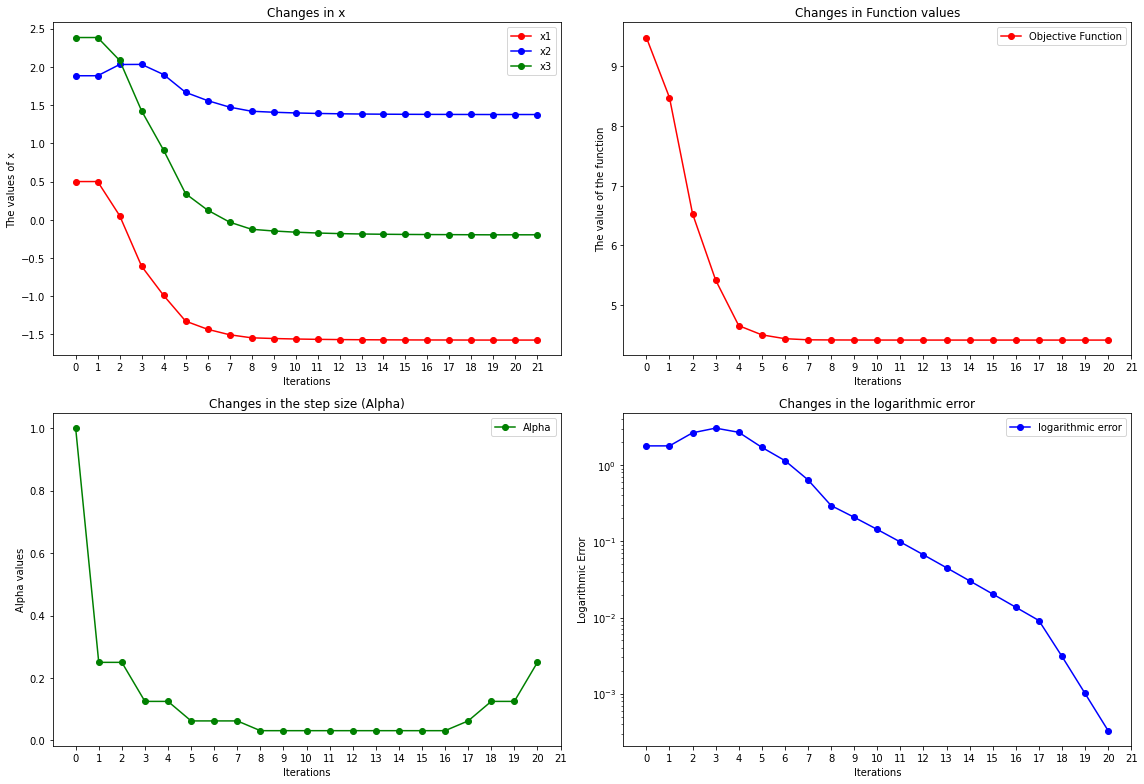

In [26]:
# printing out all the results of the optimal solution.
print(f'The iterations it took to get to the optimal solution are: {iter} \n')
print(f'The optimal solution was found at: {x.detach().numpy()}')
print(f'Final function value is: {fun(x)}\n')

# Plotting the graph in an array.
fig, ax = plt.subplots(2, 2, tight_layout = 1, figsize = (16, 11))

ax[0, 0].plot(x_num[:, 0], 'r-o')
ax[0, 0].plot(x_num[:, 1], 'b-o')
ax[0, 0].plot(x_num[:, 2], 'g-o')
ax[0, 0].legend(['x1', 'x2', 'x3'])
ax[0, 0].set(title='Changes in x')
ax[0, 0].set_xlabel('Iterations')
ax[0, 0].set_ylabel('The values of x')
ax[0, 0].set_xticks(range(len(x_num[:,0])))

ax[0, 1].plot(obj_fun, 'r-o')
ax[0, 1].legend(['Objective Function'])
ax[0, 1].set(title='Changes in Function values')
ax[0, 1].set_xlabel('Iterations')
ax[0, 1].set_ylabel('The value of the function')
ax[0, 1].set_xticks(range(len(x_num[:,0])))

ax[1, 1].plot(error, 'b-o')
ax[1, 1].legend(['logarithmic error'])
ax[1, 1].set(title='Changes in the logarithmic error')
ax[1, 1].set_xlabel('Iterations')
ax[1, 1].set_yscale('log')
ax[1, 1].set_ylabel('Logarithmic Error')
ax[1, 1].set_xticks(range(len(x_num[:,0])))

ax[1, 0].plot(a_val, 'g-o')
ax[1, 0].legend(['Alpha'])
ax[1, 0].set(title='Changes in the step size (Alpha)')
ax[1, 0].set_xlabel('Iterations')
ax[1, 0].set_ylabel('Alpha values')
ax[1, 0].set_xticks(range(len(x_num[:,0])))
plt.show()